In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import miceforest as mf
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
from lightgbm import LGBMRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_diabetes
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
# wczutuję wybrany przeze mnie zbiór danych, na którym będzie operać się praktyczna część projektu - zbiór posiada 74 kolumny i prawie 900 000 rekordów oraz bardzo dużą ilość brakujących danych 
df = pd.read_csv("dataset-2.csv")
df.head()

C:\Users\Acer\AppData\Local\Temp\ipykernel_17192\996195886.py:2: DtypeWarning: Columns (47,73) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("dataset-2.csv")


,Cst_Cnt,Btl_Cnt,Sta_ID,Depth_ID,Depthm,T_degC,Salnty,O2ml_L,STheta,O2Sat,...,R_PHAEO,R_PRES,R_SAMP,DIC1,DIC2,TA1,TA2,pH2,pH1,DIC Quality Comment
0,1,1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,0,10.50,33.440,NaN,25.649,NaN,...,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,8,10.46,33.440,NaN,25.656,NaN,...,NaN,8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,10,10.46,33.437,NaN,25.654,NaN,...,NaN,10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,19,10.45,33.420,NaN,25.643,NaN,...,NaN,19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,5,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,20,10.45,33.421,NaN,25.643,NaN,...,NaN,20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


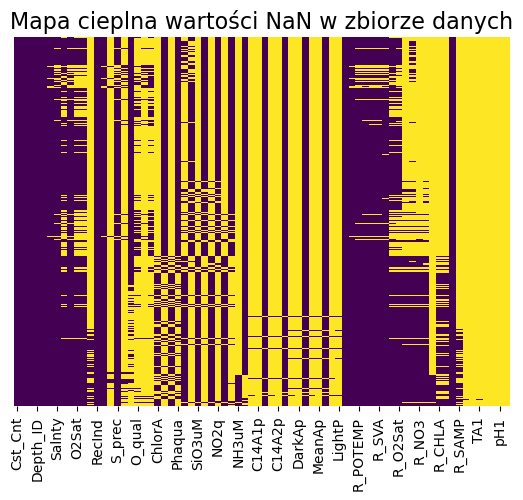

In [3]:
# w celu lepszego zobrazowania brakujących wartości tworzę mapę cieplną wartości NaN
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa cieplna wartości NaN w zbiorze danych", fontsize=16)
plt.show()

In [3]:
#  pozbywam się ze zbioru danych kolumn, któe są całkowicie lub prawie całkowicie wypełnione wartościami NaN
threshold = 1
columns = df.columns[df.isnull().mean() <= threshold]
print(columns)

Index(['Cst_Cnt', 'Btl_Cnt', 'Sta_ID', 'Depth_ID', 'Depthm', 'T_degC',
       'Salnty', 'O2ml_L', 'STheta', 'O2Sat', 'Oxy_µmol/Kg', 'BtlNum',
       'RecInd', 'T_prec', 'T_qual', 'S_prec', 'S_qual', 'P_qual', 'O_qual',
       'SThtaq', 'O2Satq', 'ChlorA', 'Chlqua', 'Phaeop', 'Phaqua', 'PO4uM',
       'PO4q', 'SiO3uM', 'SiO3qu', 'NO2uM', 'NO2q', 'NO3uM', 'NO3q', 'NH3uM',
       'NH3q', 'C14As1', 'C14A1p', 'C14A1q', 'C14As2', 'C14A2p', 'C14A2q',
       'DarkAs', 'DarkAp', 'DarkAq', 'MeanAs', 'MeanAp', 'MeanAq', 'IncTim',
       'LightP', 'R_Depth', 'R_TEMP', 'R_POTEMP', 'R_SALINITY', 'R_SIGMA',
       'R_SVA', 'R_DYNHT', 'R_O2', 'R_O2Sat', 'R_SIO3', 'R_PO4', 'R_NO3',
       'R_NO2', 'R_NH4', 'R_CHLA', 'R_PHAEO', 'R_PRES', 'R_SAMP', 'DIC1',
       'DIC2', 'TA1', 'TA2', 'pH2', 'pH1', 'DIC Quality Comment'],
      dtype='object')


In [4]:
df = df[columns]

In [5]:
df.select_dtypes("object").head() # sprawdzam czy występują dane tekstowe lub mieszane

,Sta_ID,Depth_ID,IncTim,DIC Quality Comment
0,054.0 056.0,19-4903CR-HY-060-0930-05400560-0000A-3,NaN,NaN
1,054.0 056.0,19-4903CR-HY-060-0930-05400560-0008A-3,NaN,NaN
2,054.0 056.0,19-4903CR-HY-060-0930-05400560-0010A-7,NaN,NaN
3,054.0 056.0,19-4903CR-HY-060-0930-05400560-0019A-3,NaN,NaN
4,054.0 056.0,19-4903CR-HY-060-0930-05400560-0020A-7,NaN,NaN


In [6]:
df.drop(["Sta_ID", "Depth_ID", "IncTim", "DIC Quality Comment"], axis=1, inplace=True) 

In [7]:
# sprawdzam korelację między kolumnami w celu weryfikacji zależności między danymi
corr_matrix = df.corr(numeric_only=True) 
print("Macierz korelacji:\n", corr_matrix)
if "T_degC" in df.columns: # ponieważ T_degC jest kolumną celu
    corr_with_target = corr_matrix["T_degC"].sort_values(ascending=False)
    print("\nKorelacja kolumn z T_degC:\n", corr_with_target)
else:
    print("\n...")


Macierz korelacji:
           Cst_Cnt   Btl_Cnt    Depthm    T_degC    Salnty    O2ml_L    STheta  \
Cst_Cnt  1.000000  0.999345 -0.162222  0.089329 -0.198024  0.156096 -0.089902   
Btl_Cnt  0.999345  1.000000 -0.161617  0.090118 -0.195207  0.154219 -0.089521   
Depthm  -0.162222 -0.161617  1.000000 -0.681201  0.572630 -0.592399  0.582710   
T_degC   0.089329  0.090118 -0.681201  1.000000 -0.505266  0.795700 -0.829155   
Salnty  -0.198024 -0.195207  0.572630 -0.505266  1.000000 -0.823870  0.603470   
...           ...       ...       ...       ...       ...       ...       ...   
DIC2    -0.097938 -0.097251  0.572374 -0.949972  0.955942 -0.941214  0.965546   
TA1     -0.075060 -0.074255  0.786873 -0.742196  0.895124 -0.802493  0.779899   
TA2     -0.115212 -0.114165  0.866185 -0.889635  0.937147 -0.726460  0.887778   
pH2     -0.262587 -0.259082  0.223304  0.547436  0.583807  0.174204 -0.480397   
pH1      0.020778  0.020315 -0.611798  0.743735  0.106417  0.663591 -0.717815   

       

In [8]:
df.drop(columns=["R_TEMP", "R_POTEMP", "R_SVA", "R_Depth", "R_PRES", "R_SALINITY", "R_SIGMA", "STheta"], inplace=True) # usuwam kolumny, które mają wpływ na kolumnę celu 

KeyError: "['R_TEMP', 'R_POTEMP', 'R_SVA', 'R_Depth', 'R_PRES', 'R_SALINITY', 'R_SIGMA', 'STheta'] not found in axis"

In [9]:
df = df.dropna(subset=['T_degC'])

In [18]:
# podsumowanie brakujących wartości
missing_summary = (
    df.isnull().sum()
    .to_frame(name='Missing Values')
    .reset_index()
    .rename(columns={'index': 'Column'})
)
missing_summary

,Column,Missing Values
0,Cst_Cnt,0
1,Btl_Cnt,0
2,Depthm,0
3,T_degC,0
4,Salnty,1526
...,...,...
57,DIC2,53900
58,TA1,53900
59,TA2,53900
60,pH2,53900


In [19]:
df = df.iloc[:-50000]

In [16]:
df = df.iloc[:-800000]


In [21]:
df = df.dropna(axis=1, how='all')


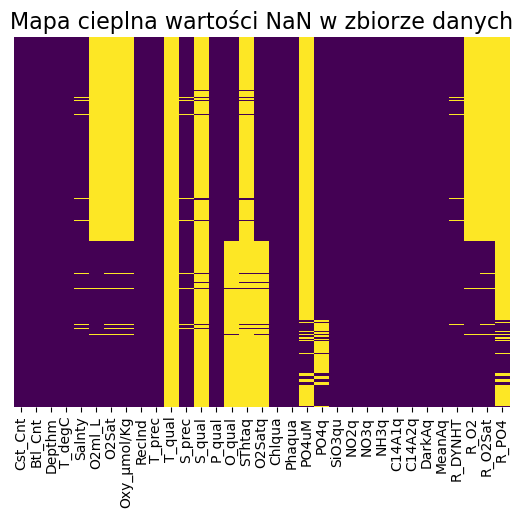

In [22]:
# w celu lepszego zobrazowania brakujących wartości tworzę mapę cieplną wartości NaN
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title("Mapa cieplna wartości NaN w zbiorze danych", fontsize=16)
plt.show()

In [ ]:
# kodują kolumnę RecInd ze względu an charakter danych - zmienna kategoryczna 

In [23]:
# sprawdzam jakie wartości przyjmuje kolumna 
df["RecInd"].value_counts(ascending=False) 

RecInd
7    2266
3    1634
Name: count, dtype: int64

In [24]:
# inicjalizacja OneHotEncodera
one_hot_encoder = OneHotEncoder(sparse_output=False) # wynik kodowania będzie tablicą NumPy
recind_one_hot = one_hot_encoder.fit_transform(df["RecInd"].to_numpy().reshape((-1, 1))) # przekształcenie kolumny RecInd na zakodowaną formę 
recind_one_hot_df = pd.DataFrame(recind_one_hot, columns=one_hot_encoder.get_feature_names_out(["RecInd"])) # Tnowy dataframe z zakodowanymi danymi 

In [25]:
# połączenie zbiorów danych
df = df.reset_index(drop=True)
recind_one_hot_df = recind_one_hot_df.reset_index(drop=True)
df = pd.concat([df, recind_one_hot_df], axis=1) # łączenie zakodowanych danych z pozostałymi
df.drop(columns=["RecInd"], axis=1, inplace=True) # usuwam kolumnę, która została zakodowana 

In [26]:
df

,Cst_Cnt,Btl_Cnt,Depthm,T_degC,Salnty,O2ml_L,O2Sat,Oxy_µmol/Kg,T_prec,T_qual,...,C14A1q,C14A2q,DarkAq,MeanAq,R_DYNHT,R_O2,R_O2Sat,R_PO4,RecInd_3,RecInd_7
0,1,1,0,10.50,33.440,NaN,NaN,NaN,1.0,NaN,...,9.0,9.0,9.0,9.0,0.00,NaN,NaN,NaN,1.0,0.0
1,1,2,8,10.46,33.440,NaN,NaN,NaN,2.0,NaN,...,9.0,9.0,9.0,9.0,0.01,NaN,NaN,NaN,1.0,0.0
2,1,3,10,10.46,33.437,NaN,NaN,NaN,2.0,NaN,...,9.0,9.0,9.0,9.0,0.02,NaN,NaN,NaN,0.0,1.0
3,1,4,19,10.45,33.420,NaN,NaN,NaN,2.0,NaN,...,9.0,9.0,9.0,9.0,0.04,NaN,NaN,NaN,1.0,0.0
4,1,5,20,10.45,33.421,NaN,NaN,NaN,2.0,NaN,...,9.0,9.0,9.0,9.0,0.04,NaN,NaN,NaN,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3895,128,3907,700,5.00,34.333,0.48,6.7,20.87011,2.0,NaN,...,9.0,9.0,9.0,9.0,1.11,0.48,6.7,NaN,0.0,1.0
3896,128,3908,800,4.69,34.390,0.45,6.3,19.56419,2.0,NaN,...,9.0,9.0,9.0,9.0,1.21,0.45,6.3,NaN,0.0,1.0
3897,128,3909,834,4.58,34.410,0.44,6.1,19.12891,2.0,NaN,...,9.0,9.0,9.0,9.0,1.24,0.44,6.1,NaN,1.0,0.0
3898,129,3915,0,14.50,33.710,5.68,98.1,247.46100,2.0,NaN,...,9.0,9.0,9.0,9.0,0.00,5.68,98.1,0.49,1.0,0.0


In [27]:
y=df['T_degC']
x=df.drop('T_degC',axis=1)
x_train,x_test,y_train,y_test=train_test_split(x,y,train_size=0.7,random_state=42,shuffle=True)

In [28]:
# Imputacja braków metodą wypełniania zerami
imp_zero = SimpleImputer(strategy='constant', fill_value=0)
x_train_imputed = imp_zero.fit_transform(x_train)
x_test_imputed = imp_zero.transform(x_test)

In [29]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [30]:
models={'Linear Regression':LinearRegression(),
           'Decision Tree':DecisionTreeRegressor(),
           'Random Forest':RandomForestRegressor(n_estimators=100, max_depth=3, random_state=42),
            'Gradient Boosting':GradientBoostingRegressor(random_state=42, n_estimators=100, learning_rate=0.1, max_depth=3)}

In [31]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 1.80
MAE: 1.04
RMSE: 1.34
R²: 0.87
------------------------------
Model: Decision Tree
MSE: 0.51
MAE: 0.37
RMSE: 0.71
R²: 0.96
------------------------------
Model: Random Forest
MSE: 1.54
MAE: 0.90
RMSE: 1.24
R²: 0.89
------------------------------
Model: Gradient Boosting
MSE: 0.38
MAE: 0.41
RMSE: 0.62
R²: 0.97
------------------------------


In [42]:
# Imputacja braków metodą wypełniania medianą
imp_median = SimpleImputer(strategy='median')
x_train_imputed = imp_median.fit_transform(x_train)
x_test_imputed = imp_median.transform(x_test)

In [43]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [44]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 3.06
MAE: 1.36
RMSE: 1.75
R²: 0.78
------------------------------
Model: Decision Tree
MSE: 0.53
MAE: 0.37
RMSE: 0.73
R²: 0.96
------------------------------
Model: Random Forest
MSE: 1.57
MAE: 0.91
RMSE: 1.25
R²: 0.89
------------------------------
Model: Gradient Boosting
MSE: 0.41
MAE: 0.42
RMSE: 0.64
R²: 0.97
------------------------------


In [32]:
def multiple_imputation_mice(train, test, num_imputations=3):
    train_imputed_datasets = []
    test_imputed_datasets = []

    for i in range(num_imputations):

        mice_imputer = IterativeImputer(random_state=i, max_iter=10, sample_posterior=True)

        # Imputacja dla zbioru treningowego
        imputed_train = pd.DataFrame(mice_imputer.fit_transform(train), columns=train.columns)
        train_imputed_datasets.append(imputed_train)

        # Imputacja dla zbioru testowego
        imputed_test = pd.DataFrame(mice_imputer.transform(test), columns=test.columns)
        test_imputed_datasets.append(imputed_test)

    # gregacja wyników imputacji
    aggregated_train = pd.concat(train_imputed_datasets).groupby(level=0).mean()
    aggregated_test = pd.concat(test_imputed_datasets).groupby(level=0).mean()

    return aggregated_train, aggregated_test

aggregated_train, aggregated_test = multiple_imputation_mice(x_train, x_test, num_imputations=3)

In [33]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(aggregated_train)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
aggregated_train_scaled = pd.DataFrame(scaler.transform(aggregated_train), columns=aggregated_train.columns, index=aggregated_train.index)
aggregated_test_scaled = pd.DataFrame(scaler.transform(aggregated_test), columns=aggregated_test.columns, index=aggregated_test.index)

In [34]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(aggregated_train_scaled, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(aggregated_test_scaled)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 3.29
MAE: 1.40
RMSE: 1.81
R²: 0.77
------------------------------
Model: Decision Tree
MSE: 1.03
MAE: 0.50
RMSE: 1.01
R²: 0.93
------------------------------
Model: Random Forest
MSE: 1.56
MAE: 0.91
RMSE: 1.25
R²: 0.89
------------------------------
Model: Gradient Boosting
MSE: 0.48
MAE: 0.44
RMSE: 0.69
R²: 0.97
------------------------------


In [35]:
# Imputacja braków metodą wypełniania knn
imp_knn = KNNImputer(n_neighbors=3)
x_train_imputed = imp_knn.fit_transform(x_train)
x_test_imputed = imp_knn.transform(x_test)

In [36]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [37]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 1.84
MAE: 0.99
RMSE: 1.36
R²: 0.87
------------------------------
Model: Decision Tree
MSE: 0.49
MAE: 0.37
RMSE: 0.70
R²: 0.96
------------------------------
Model: Random Forest
MSE: 1.49
MAE: 0.89
RMSE: 1.22
R²: 0.89
------------------------------
Model: Gradient Boosting
MSE: 0.37
MAE: 0.40
RMSE: 0.61
R²: 0.97
------------------------------


In [38]:
# Funkcja imputacji LightGBM
def lightgbm_imputation_train_test(x_train, x_test):
    x_train = x_train.copy()
    x_test = x_test.copy()
    
    for column in x_train.columns:
        missing_train = x_train[column].isnull()
        missing_test = x_test[column].isnull()
        
        if missing_train.any() or missing_test.any():
            # Przygotowanie danych do modelu
            x_train_features = x_train.loc[~missing_train].drop(columns=column)
            y_train = x_train.loc[~missing_train, column]
            
            x_test_features = x_test.drop(columns=column)
            
            # LightGBM - imputacja na zbiorze treningowym
            model = LGBMRegressor(random_state=42)
            model.fit(x_train_features, y_train)
            
            # Imputacja braków w zbiorze treningowym
            if missing_train.any():
                x_train.loc[missing_train, column] = model.predict(x_train.loc[missing_train].drop(columns=column))
            
            # Imputacja braków w zbiorze testowym
            if missing_test.any():
                x_test.loc[missing_test, column] = model.predict(x_test_features.loc[missing_test])
    
    return x_train, x_test

x_train_imputed, x_test_imputed = lightgbm_imputation_train_test(x_train, x_test)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2293
[LightGBM] [Info] Number of data points in the train set: 2667, number of used features: 20
[LightGBM] [Info] Start training from score 33.785008
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000506 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 1231, number of used features: 19
[LightGBM] [Info] Start training from score 3.137084
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000317 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2171
[LightGBM] [Info] Number of data points in the train set:

In [39]:
# Skalowanie danych
scaler = StandardScaler()
scaler.fit(x_train_imputed)
# Przekształcenie danych do DataFrame z odpowiednimi nazwami kolumn
x_train_imputed = pd.DataFrame(scaler.transform(x_train_imputed), columns=x_train.columns, index=x_train.index)
x_test_imputed = pd.DataFrame(scaler.transform(x_test_imputed), columns=x_test.columns, index=x_test.index)

In [40]:
# iteracja po każdym modelu
for name, model in models.items():
    # irenowanie modelu na danych treningowych
    model.fit(x_train_imputed, y_train)
    
    # predykcja na zbiorze testowym
    y_pred = model.predict(x_test_imputed)
    
    # obliczanie metryk
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # wyświetlenie wyników dla aktualnego modelu
    print(f"Model: {name}")
    print("MSE: {:.2f}".format(mse))
    print("MAE: {:.2f}".format(mae))
    print("RMSE: {:.2f}".format(rmse))
    print("R²: {:.2f}".format(r2))
    print("-" * 30)

Model: Linear Regression
MSE: 1.58
MAE: 0.91
RMSE: 1.26
R²: 0.89
------------------------------
Model: Decision Tree
MSE: 0.57
MAE: 0.40
RMSE: 0.76
R²: 0.96
------------------------------
Model: Random Forest
MSE: 1.59
MAE: 0.91
RMSE: 1.26
R²: 0.89
------------------------------
Model: Gradient Boosting
MSE: 0.41
MAE: 0.41
RMSE: 0.64
R²: 0.97
------------------------------


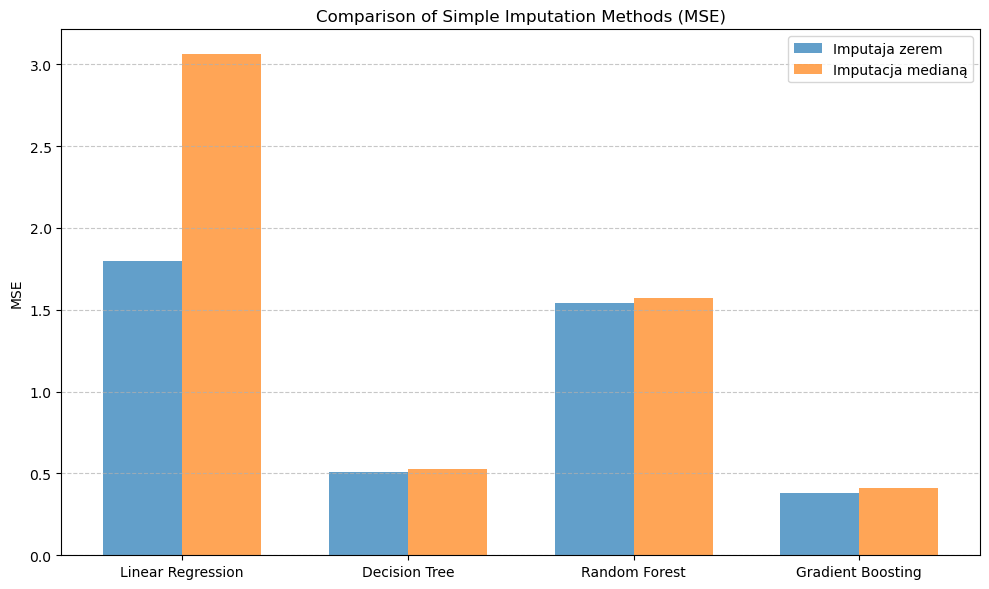

In [6]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['Imputation Zero', 'Imputation Median']
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [1.80, 0.51, 1.54, 0.38]
mse_median = [3.06, 0.53, 1.57, 0.41]
x = np.arange(len(models)) 
width = 0.35  
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mse_zero, width, label='Imputaja zerem', alpha=0.7)
plt.bar(x + width/2, mse_median, width, label='Imputacja medianą', alpha=0.7)
plt.ylabel('MSE')
plt.title('Comparison of Simple Imputation Methods (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

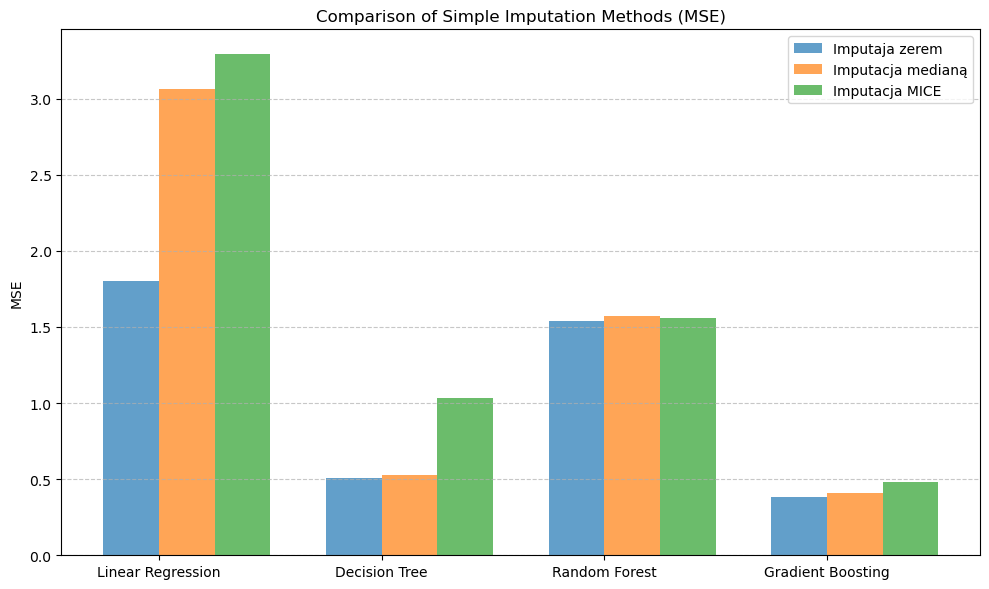

In [29]:
import matplotlib.pyplot as plt
import numpy as np
methods = ['Imputation Zero', 'Imputation Median']
models = ['Linear Regression', 'Decision Tree', 'Random Forest', 'Gradient Boosting']
mse_zero = [1.80, 0.51, 1.54, 0.38]
mse_median = [3.06, 0.53, 1.57, 0.41]
mse_mice = [3.29, 1.03, 1.56, 0.48]
x = np.arange(len(models)) 
width = 0.25 
plt.figure(figsize=(10, 6))
plt.bar(x - width/2, mse_zero, width, label='Imputaja zerem', alpha=0.7)
plt.bar(x + width/2, mse_median, width, label='Imputacja medianą', alpha=0.7)
plt.bar(x + width*1.5, mse_mice, width, label='Imputacja MICE', alpha=0.7)
# Etykiety i tytuły
plt.ylabel('MSE')
plt.title('Comparison of Simple Imputation Methods (MSE)')
plt.xticks(x, models)
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [30]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")
data = {
    "method": [
        "zero", "zero", "zero", "zero",
        "mediana", "mediana", "mediana", "mediana",
        "MICE", "MICE", "MICE", "MICE",
        "KNN", "KNN", "KNN", "KNN",
        "LightGBM", "LightGBM", "LightGBM", "LightGBM"
    ],
    "model": [
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB",
        "LR", "DT", "RF", "GB"
    ],
    "R2": [
        0.87, 0.96, 0.89, 0.97,
        0.78, 0.96, 0.89, 0.97,
        0.77, 0.93, 0.89, 0.97,
        0.87, 0.96, 0.89, 0.97,
        0.89, 0.96, 0.89, 0.97
        
    ],
    "MSE": [
        1.80, 0.51, 1.54, 0.38,
        3.06, 0.53, 1.57, 0.41,
        3.29, 1.03, 1.56, 0.48,
        1.84, 0.49, 1.49, 0.37,
        1.58, 0.57, 1.59, 0.41
    ]
}

df = pd.DataFrame(data)
print(df)

      method model    R2   MSE
0       zero    LR  0.87  1.80
1       zero    DT  0.96  0.51
2       zero    RF  0.89  1.54
3       zero    GB  0.97  0.38
4    mediana    LR  0.78  3.06
5    mediana    DT  0.96  0.53
6    mediana    RF  0.89  1.57
7    mediana    GB  0.97  0.41
8       MICE    LR  0.77  3.29
9       MICE    DT  0.93  1.03
10      MICE    RF  0.89  1.56
11      MICE    GB  0.97  0.48
12       KNN    LR  0.87  1.84
13       KNN    DT  0.96  0.49
14       KNN    RF  0.89  1.49
15       KNN    GB  0.97  0.37
16  LightGBM    LR  0.89  1.58
17  LightGBM    DT  0.96  0.57
18  LightGBM    RF  0.89  1.59
19  LightGBM    GB  0.97  0.41


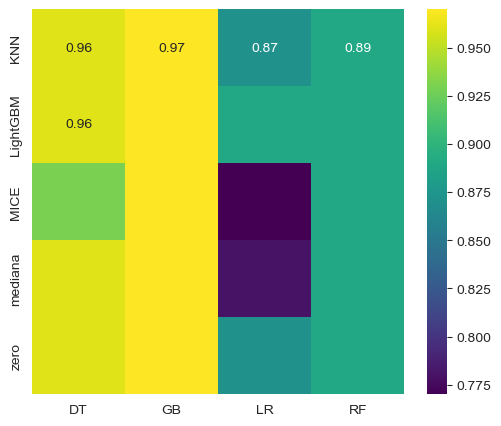

In [31]:
df_pivot_r2 = df.pivot(index="method", columns="model", values="R2")
plt.figure(figsize=(6, 5))
sns.heatmap(df_pivot_r2, annot=True, cmap="viridis", fmt=".2f")
plt.title("")
plt.xlabel("")
plt.ylabel("")
plt.show()

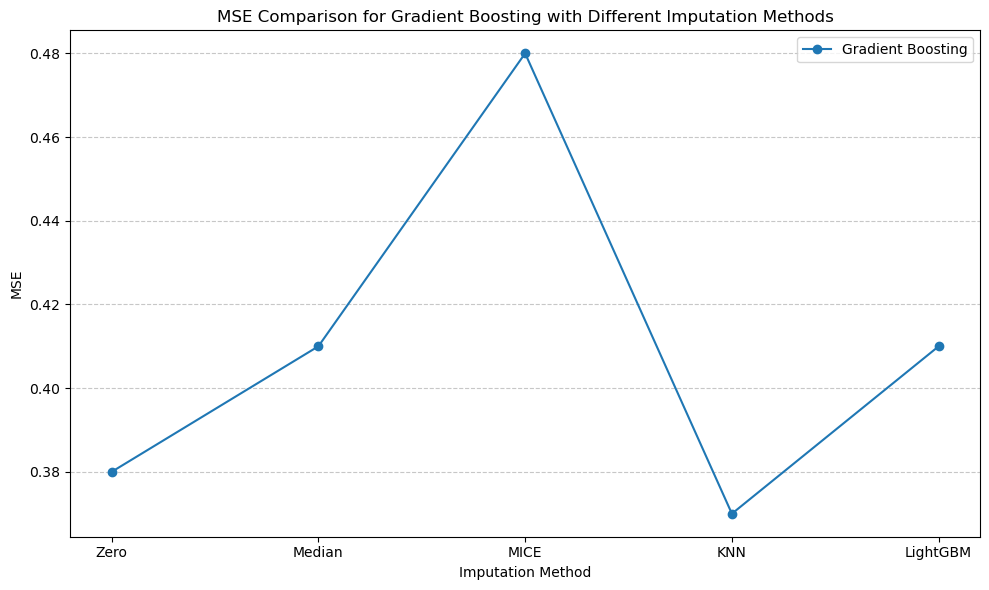

In [4]:
# Dane dla gradient boosting
mse_methods = [0.38, 0.41, 0.48, 0.37, 0.41]
methods = ['Zero', 'Median', 'MICE', 'KNN', 'LightGBM']
plt.figure(figsize=(10, 6))
plt.plot(methods, mse_methods, marker='o', linestyle='-', label='Gradient Boosting')
plt.ylabel('MSE')
plt.xlabel('Imputation Method')
plt.title('MSE Comparison for Gradient Boosting with Different Imputation Methods')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()